# Trabalhando com dataset

Estudaremos práticas comuns ao trabalhar com datasets

### Carregando os dados

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader # Responsável por lidar com os dados
from torchvision import datasets

# Diretório no qual as imagens serão armazenadas
root = '../data'
ds_or = datasets.MNIST(root, train=True, download=True)

img, target = ds_or[0]
print(type(img))
print(target)
img

<class 'PIL.Image.Image'>
5


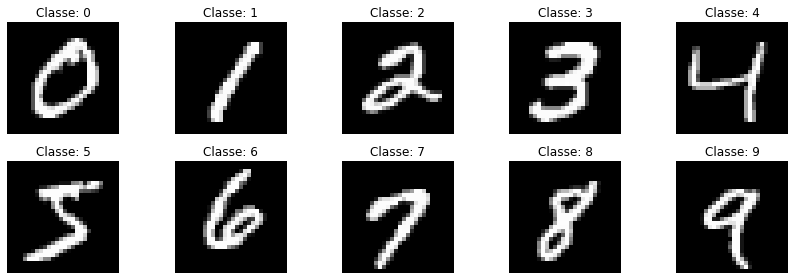

In [14]:
# Plota um digito de cada classe
fig, axs = plt.subplots(2, 5, figsize=(12, 4))  
class_plotted = set()

idx = 0
while len(class_plotted) < 10:  
    img, target = ds_or[idx]
    if target not in class_plotted:  
        ax = axs[target // 5, target % 5]  
        ax.imshow(img, 'gray')
        ax.set_title(f'Classe: {target}')
        ax.axis('off')  
        class_plotted.add(target)  
    idx += 1 

plt.tight_layout()
plt.show()

### Extração de um subconjunto para agilizar os testes

Iremos extrair um subconjunto do MNIST. Para isso, criaremos uma Dataset do Pytorch contendo um subconjunto das imagens

In [3]:
class Subset(Dataset):

    def __init__(self, ds, indices):
        self.ds = ds # Dataset original
        self.indices = indices # Indices do subset que será usado de fato

    def __getitem__(self, idx):
        return self.ds[self.indices[idx]]

    def __len__(self):
        return len(self.indices)
    
# Semente do gerador de números aleatórios
random.seed(42)
# Dataset com 1000 imagens
indices = random.sample(range(len(ds_or)), k=1000)
ds = Subset(ds_or, indices)
len(ds)

1000

### Normalização dos dados

A normalização dos dados é uma técnica crucial no pré-processamento de dados para aprendizado de máquina, especialmente em redes neurais. Essa prática envolve ajustar os dados de entrada para que tenham uma `média zero e desvio padrão de um`. Este procedimento ajuda a melhorar a convergência durante o treinamento, reduzir a dependência de características em escalas particulares e aumentar a eficiência geral do algoritmo de aprendizado.

#### Importância da Normalização

- **Melhoria da Convergência do Treinamento:** Dados normalizados ajudam a otimizar o processo de aprendizado, pois garantem que todas as características contribuam igualmente para o cálculo do erro e a atualização dos pesos. Isso `evita problemas relacionados com a escala dos dados`, onde variáveis de maior magnitude dominam o processo de treinamento, potencialmente levando a um treinamento mais lento ou até mesmo a falhas na convergência.

- **Prevenção de Viés nos Pesos:** Sem normalização, as características com maior variação inicial podem influenciar desproporcionalmente os pesos da rede, tornando o modelo enviesado para essas características. A normalização neutraliza esse efeito, permitindo que o modelo aprenda de forma mais equilibrada.

#### Como Normalizar os Dados

1. **Cálculo da Média e Desvio Padrão:**
   Para normalizar os dados, primeiramente calculamos a média ($(\mu)$) e o desvio padrão ($(\sigma)$) de cada característica no conjunto de dados:
   $$
   \mu = \frac{1}{N} \sum_{i=1}^{N} x_i, \quad \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
   $$
   onde $(x_i)$ são os valores de uma característica específica, e $(N)$ é o número total de amostras.

2. **Aplicação da Normalização:**
   Em seguida, cada característica é normalizada subtraindo a média e dividindo pelo desvio padrão:
   $$
   x_{\text{norm}} = \frac{x - \mu}{\sigma}
   $$
   Isso resulta em características com uma média aproximadamente zero e um desvio padrão de um.

In [4]:
def get_statistics(ds):

    n = len(ds)
    mean = 0.
    std = 0.
    for img, target in ds:
        mean += np.mean(np.array(img))
        std += np.std(np.array(img))
    mean /= n
    std /= n

    return mean, std

print(get_statistics(ds))

(32.96950255102037, 76.55556595768888)


In [5]:
def transform(img, mean=33., std=76.5):
    """Transformação do dataset MNIST. PIL->numpy->z-score->tensor."""
    
    # Conversão PIL->numpy
    img = np.array(img, dtype=np.float32)
    # Conversão numpy->pytorch
    img = torch.from_numpy(img)
    # Normalização
    img = (img-mean)/std
    # Adição de um canal
    img = img.reshape(1, img.shape[0], img.shape[1])

    return img

### Classe final

In [17]:
class Subset(Dataset):

    def __init__(self, ds, indices, transform=None):
        self.ds = ds
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        """Retorna um item, opcionalmente aplicando uma transformação."""

        img, target = self.ds[self.indices[idx]]
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.indices)
    
# Podemos criar subsets de treinamento e validação
random.seed(42)
indices = random.sample(range(len(ds_or)), k=2000)
mean, std = get_statistics(ds)
ds_train = Subset(ds_or, indices[:1000], transform=transform)
ds_valid = Subset(ds_or, indices[1000:], transform=transform)

### DataLoader do PyTorch

O `DataLoader` é uma classe essencial no PyTorch que facilita o carregamento de dados, tornando-o mais acessível e gerenciável durante o treinamento de modelos de aprendizado de máquina. Ele é usado para encapsular um conjunto de dados e oferecer várias funcionalidades de iteração sobre os dados de forma eficiente e fácil.

#### Principais Funcionalidades

- **Batch Loading**: O `DataLoader` permite o carregamento de dados em lotes, o que é crucial para o treinamento de modelos em grandes conjuntos de dados. Isso ajuda a otimizar o uso da memória e acelerar o processo de treinamento.

- **Shuffling**: A classe pode embaralhar os dados automaticamente a cada época para reduzir o risco de overfitting e melhorar a generalização do modelo.

- **Parallel Processing**: Utiliza workers múltiplos para carregar os dados, permitindo que o carregamento de dados seja feito de forma assíncrona e paralela, melhorando significativamente a eficiência durante o treinamento.

#### Principais Métodos e Parâmetros

- **`__init__(self, dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)`**:
  - `dataset`: O conjunto de dados a ser carregado pelo DataLoader.
  - `batch_size`: Define o tamanho de cada lote de dados.
  - `shuffle`: Se `True`, os dados serão embaralhados a cada iteração (ou época).
  - `num_workers`: Número de subprocessos a serem usados para carregar os dados. Um valor maior pode acelerar o carregamento dos dados.
  - `collate_fn`: Define como as amostras são combinadas para formar um lote. Pode ser personalizado para maneiras específicas de combinação de dados.
  - `pin_memory`: Se `True`, o DataLoader colocará os tensores em uma área da memória que é mais rápida para transferência para a GPU.
  - `drop_last`: Se `True`, o último lote será descartado caso seu tamanho seja menor que o tamanho definido em `batch_size`.

In [7]:
dl = DataLoader(ds_train, 
                batch_size=16,   # Número de imagens que serão incluídas em um batch
                shuffle=True,    # Define se as imagens serão amostradas aleatoriamente
                num_workers=0,   # Número de threads que serão usadas para carregar os dados
                drop_last=False) # Indica se o último batch será desconsiderado

imgs, targets = next(iter(dl))
print(imgs.shape, targets.shape)

torch.Size([16, 1, 28, 28]) torch.Size([16])


- **Métodos de Iteração**: O DataLoader pode ser usado diretamente em loops, fornecendo uma maneira conveniente de iterar sobre os dados em lotes.

In [8]:
for imgs, targets in dl:
    print(imgs.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 28, 28])
torch.Size([16, 1, 2